# CA1 - Kaplan-Meier survival curves
August Noer Steinset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [2]:
treatment_list = [1,5,6,6,9,10,10,10,12,12,12,12,12,13,15,16,20,24,24,27,32,34,36,36,44]
treatment_event = [0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0]

control_list = [3,6,6,6,6,8,8,12,12,12,15,16,18,18,20,22,24,28,28,28,30,30,33,42]
control_event = [0,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1]

## Task 1

In [3]:
# average survival time for the two groups
treatment_mean = np.mean(treatment_list)
control_mean = np.mean(control_list)
print('treatment_mean:', treatment_mean)
print('control_mean:', control_mean)

treatment_mean: 17.52
control_mean: 17.958333333333332


In [4]:
# avergage hazard for the two groups
treatment_hazard_ratio = sum(treatment_event)/sum(treatment_list)
control_hazard_ratio = sum(control_event)/sum(control_list)
print('treatment_hazard_ratio:', treatment_hazard_ratio)
print('control_hazard_ratio:', control_hazard_ratio)

treatment_hazard_ratio: 0.0228310502283105
control_hazard_ratio: 0.027842227378190254


In [5]:
# average hazard ratio for the two groups
hazard_ratio = treatment_hazard_ratio/control_hazard_ratio
print('hazard_ratio:', hazard_ratio)

hazard_ratio: 0.8200152207001522


While the average survival time of the treatment group is worse, we can see from the other numbers that this might be mostly because of the censoring. The treatment group in general experiences less hazard than the controll group.

## Task 2

Ignoring the merging of time rows into one another if the event does not occure. This makes a larger table, but the maths stays the same as we only see a change in survival probability once an event happens.

In [6]:
# Function for generating the Kaplan-Meier table.
def create_event_table(time_list, event_list):
    df = pd.DataFrame({
        't': time_list,
        'event': event_list
    }).sort_values(by='t')
    
    times = df['t'].unique()
    at_risk = len(df)
    event_table = []
    
    for t in times:
        observed = df[df['t'] == t]['event'].sum()
        censored = len(df[df['t'] == t]) - observed
        event_table.append((t, observed, censored, at_risk))
        at_risk -= censored
        at_risk -= observed
        
    
    return pd.DataFrame(event_table, columns=['t', 'm', 'q', 'n'])

# Create event tables
treatment_table = create_event_table(treatment_list, treatment_event)
control_table = create_event_table(control_list, control_event)

treatment_table

,t,m,q,n
0,1,0,1,25
1,5,0,1,24
2,6,2,0,23
3,9,0,1,21
4,10,2,1,20
5,12,4,1,17
6,13,0,1,12
7,15,0,1,11
8,16,0,1,10
9,20,0,1,9


In [7]:
def compute_km(event_table):
    times = [0]
    probabilities = [1]
    
    for _, row in event_table.iterrows():
        t = row['t']
        prob = (1 - (row['m'] / row['n']))
        S_t = probabilities[-1] * prob
        probabilities.append(S_t)
        times.append(t)
    
    return times, probabilities

# Compute KM probabilities
treatment_times, treatment_probs = compute_km(treatment_table)
control_times, control_probs = compute_km(control_table)

print('treatment_times:', treatment_times)
print('treatment_probs:', treatment_probs)

treatment_times: [0, 1, 5, 6, 9, 10, 12, 13, 15, 16, 20, 24, 27, 32, 34, 36, 44]
treatment_probs: [1, 1.0, 1.0, 0.9130434782608696, 0.9130434782608696, 0.8217391304347826, 0.628388746803069, 0.628388746803069, 0.628388746803069, 0.628388746803069, 0.628388746803069, 0.5498401534526853, 0.5498401534526853, 0.43987212276214827, 0.43987212276214827, 0.43987212276214827, 0.43987212276214827]


## Task 3

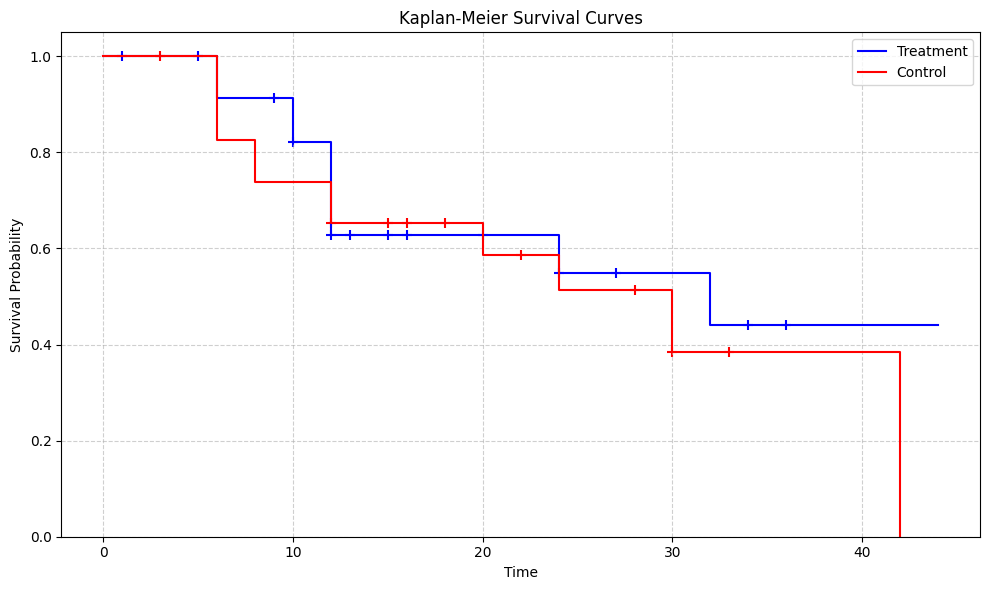

In [8]:
def plot_censoring_points(event_table, times, probabilities, color):
    """Plots + signs at the points of censoring."""
    for _, row in event_table.iterrows():
        if row['q'] > 0:
            # get the survival probability just before this time point
            idx = next((i for i, time in enumerate(times) if time > row['t']), None)
            if idx is not None:
                plt.scatter(row['t'], probabilities[idx-1], color=color, marker='+', s=60, linewidth=1.5)

# Plotting
plt.figure(figsize=(10, 6))

# KM Curves
plt.step(treatment_times, treatment_probs, where='post', color='blue', label='Treatment')
plt.step(control_times, control_probs, where='post', color='red', label='Control')

# Plotting censoring points
plot_censoring_points(treatment_table, treatment_times, treatment_probs, 'blue')
plot_censoring_points(control_table, control_times, control_probs, 'red')

# Other plotting details
plt.title('Kaplan-Meier Survival Curves')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [9]:
# Find the median survival time for both groups
def find_median_time(times, probabilities):
    for i, prob in enumerate(probabilities):
        if prob < 0.5:
            return times[i-1]
    return None

treatment_median = find_median_time(treatment_times, treatment_probs)
control_median = find_median_time(control_times, control_probs)

print('treatment_median:', treatment_median)
print('control_median:', control_median)

treatment_median: 27
control_median: 28


## Task 4

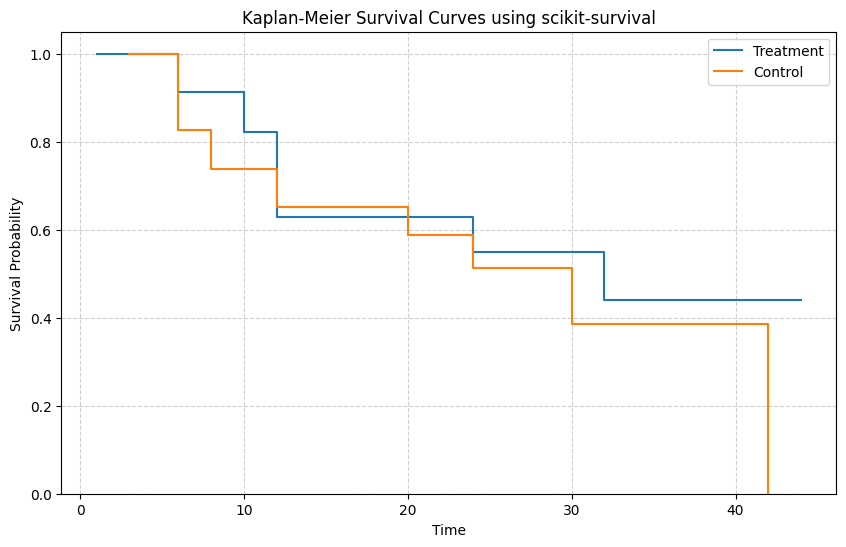

In [10]:
# Convert data to structured array format
def prepare_data(time_list, event_list):
    data = np.zeros(len(time_list), dtype=[('time', np.float64), ('event', np.bool_)])
    data['time'] = time_list
    data['event'] = event_list
    return data

treatment_data = prepare_data(treatment_list, treatment_event)
control_data = prepare_data(control_list, control_event)

# Compute the Kaplan-Meier estimator for both groups
time_treatment, survival_prob_treatment = kaplan_meier_estimator(treatment_data["event"], treatment_data["time"])
time_control, survival_prob_control = kaplan_meier_estimator(control_data["event"], control_data["time"])

# Plotting
plt.figure(figsize=(10, 6))
plt.step(time_treatment, survival_prob_treatment, where="post", label="Treatment")
plt.step(time_control, survival_prob_control, where="post", label="Control")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curves using scikit-survival")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.show()


In [11]:
# find the median survival time for both groups using the scikit-survival data

# Compute median survival times
def compute_median_survival_time(time, survival_prob):
    median_time = None
    for t, prob in zip(time, survival_prob):
        if prob <= 0.5:
            median_time = t
            break
    return median_time

median_time_treatment = compute_median_survival_time(time_treatment, survival_prob_treatment)
median_time_control = compute_median_survival_time(time_control, survival_prob_control)

print('median_time_treatment:', median_time_treatment)
print('median_time_control:', median_time_control)

median_time_treatment: 32.0
median_time_control: 30.0


The median is different from what i found, this has to do with me not merging the rows in the table. So it registers 27 and 28, even though they should not be there as these only contain censored events.